## Introduction

In this notebook, we are going to fine-tune the LayoutLM model by Microsoft Research on the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, which is a collection of annotated form documents. The goal of our model is to learn the annotations of a number of labels ("question", "answer", "header" and "other") on those forms, such that it can be used to annotate unseen forms in the future.

* Original LayoutLM paper: https://arxiv.org/abs/1912.13318

* Original FUNSD paper: https://arxiv.org/abs/1905.13538


## Install libraries

Currently you have to first install the `unilm` package, and then the `transformers` package (which updates the outdated `transformers` package that is included in the `unilm` package). The reason we also install the `unilm` package is because we need its preprocessing files. I've forked it, and removed some statements which introduced some issues.

In [43]:
import torch

In [ ]:
# ! rm -r unilm
# ! git clone -b remove_torch_save https://github.com/NielsRogge/unilm.git
! cd unilm/layoutlm
! pip install unilm/layoutlm

In [ ]:
! rm -r transformers
! git clone https://github.com/huggingface/transformers.git
! cd transformers
! pip install ./transformers

## Getting the data

Here we download the data of the [FUNSD dataset](https://guillaumejaume.github.io/FUNSD/) from the web. This results in a directory called "data" being created, which has 2 subdirectories, one for training and one for testing. Each of those has 2 subdirectories in turn, one containing the images as png files and one containing the annotations in json format.

In [ ]:
! wget https://guillaumejaume.github.io/FUNSD/dataset.zip
! unzip dataset.zip && mv dataset data && rm -rf dataset.zip __MACOSX

Let's take a look at a training example. For this, we are going to use PIL (Python Image Library).

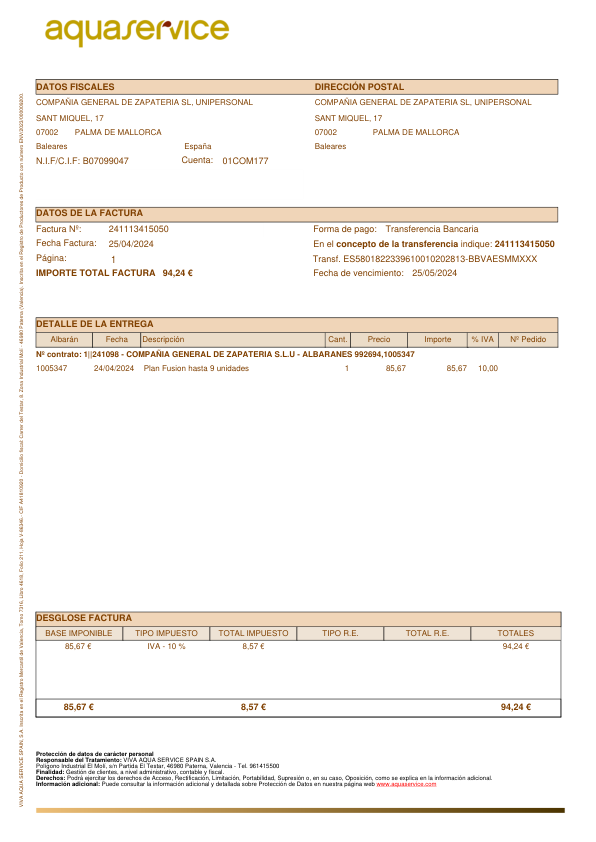

In [1]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(fr"dataset\testing_data\images\aigua.png")
image = image.convert("RGB")
image

Now let's plot its corresponding annotations. Basically, if you type `data['form']`, you get a list of all general annotations. Each general annotation has a label, a bounding box, and one or more words, which in also have their own bounding box. The bounding boxes are in [xleft, ytop, xright, ybottom] format.
 

In [2]:
import json

with open(fr'dataset\training_data\annotations\aigua.json') as f:
  data = json.load(f)
print(data)
for annotation in data['form']:
  print(annotation)

{'form': [{'box': [36, 750, 67, 759], 'text': 'DATOS', 'label': 'others', 'words': [{'text': 'DATOS', 'box': [36, 750, 67, 759]}], 'linking': [], 'id': '02e98c5a-9553-4fa8-a7b9-a55815ecfc03'}, {'box': [70, 750, 114, 759], 'text': 'FISCALES', 'label': 'others', 'words': [{'text': 'FISCALES', 'box': [70, 750, 114, 759]}], 'linking': [], 'id': '57f14ce5-8fa6-4df7-8118-6f64a5ac6b5a'}, {'box': [314, 750, 365, 759], 'text': 'DIRECCIÓN', 'label': 'others', 'words': [{'text': 'DIRECCIÓN', 'box': [314, 750, 365, 759]}], 'linking': [], 'id': '668d01b1-1aea-4b9d-9938-de095148f014'}, {'box': [367, 750, 404, 759], 'text': 'POSTAL', 'label': 'others', 'words': [{'text': 'POSTAL', 'box': [367, 750, 404, 759]}], 'linking': [], 'id': 'ecfd476a-9d17-4a5b-b110-da15bf85f0c0'}, {'box': [36, 735, 78, 743], 'text': 'COMPAÑIA', 'label': 'others', 'words': [{'text': 'COMPAÑIA', 'box': [36, 735, 78, 743]}], 'linking': [], 'id': 'f9f36d43-7711-45f9-a321-6ab880eb93b0'}, {'box': [80, 735, 119, 743], 'text': 'GENER

The PIL library has a handy ImageDraw module, which -you guessed it- allows to draw things (such as rectangles) on an image:

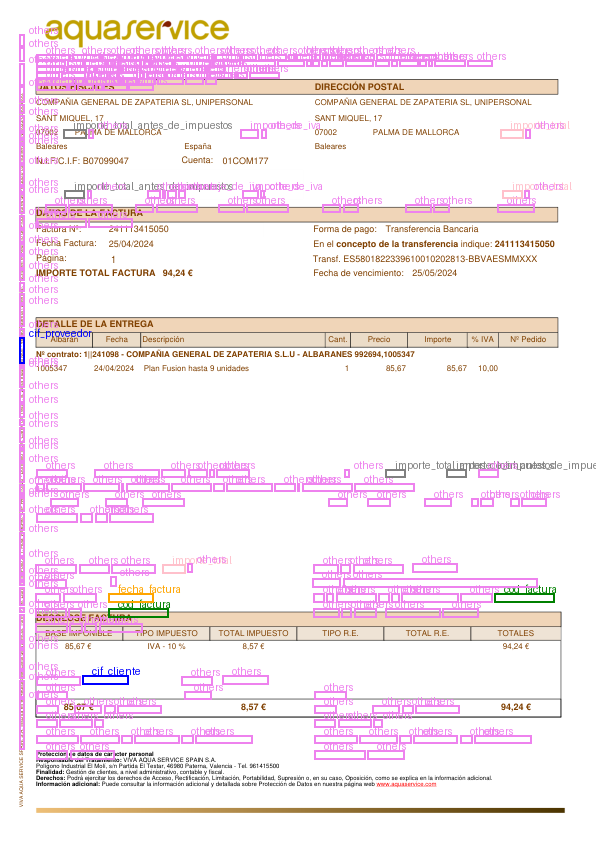

In [3]:
draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {'cif_proveedor':'blue', 'cif_cliente':'blue', 'cod_factura':'green', 'fecha_factura':'orange', 'others':'violet', 'fecha_vencimiento':'magenta', 'importe_total':'pink', 'importe_total_antes_de_impuestos':'grey', 'importe_de_iva':'violet', 'porcentaje_de_iva':'violet'}

for annotation in data['form']:
  label = annotation['label']
  general_box = annotation['box']
  if not label:
    continue
    
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  
  words = annotation['words']
  for word in words:
    box = word['box']
    draw.rectangle(box, outline=label2color[label], width=1)
    
  


image

## Preprocessing the data

Next, we need to turn the document images into individual tokens and corresponding labels (BIOES format, see further). We do this both for the training and test datasets. Make sure to run this from the `/content` directory:

In [4]:
! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir dataset/training_data/annotations \
                                                      --data_split train \
                                                      --output_dir dataset/ \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir dataset/testing_data/annotations \
                                                      --data_split test \
                                                      --output_dir dataset/ \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

Next, we create a labels.txt file that contains the unique labels of the FUNSD dataset:

In [5]:
# ! cat dataset/train.txt | cut -d$'\t' -f 2 | grep -v "^$"| sort | uniq > dataset/labels.txt

def process_file(input_file, output_file):
    # Abrir el archivo de entrada y leer sus líneas
    with open(input_file, 'r', encoding='utf-8') as f:
        # Leer y dividir las líneas, extrayendo la segunda columna
        lines = f.readlines()
        second_column = [line.split('\t')[1].strip() for line in lines if line.strip()]

    # Eliminar duplicados y ordenar las líneas
    unique_sorted_lines = sorted(set(second_column))

    # Guardar el resultado en el archivo de salida
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write("\n".join(unique_sorted_lines) + "\n")

    print(f"Archivo procesado y guardado en {output_file}")

# Uso de la función
input_file = 'dataset/train.txt'
output_file = 'dataset/labels.txt'
process_file(input_file, output_file)


Archivo procesado y guardado en dataset/labels.txt


## Define a PyTorch dataset

First, we create a list containing the unique labels based on `data/labels.txt` (run this from the content directory):

In [6]:
from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("dataset/labels.txt")

num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

We can see that the dataset uses the so-called BIOES annotation scheme to annotate the tokens. This means that a given token can be either at the beginning (B), inside (I), outside (O), at the end (E) or start (S) of a given entity. Entities include ANSWER, QUESTION, HEADER and OTHER: 

In [7]:
print(labels)

['O', 'S-CIF_CLIENTE', 'S-CIF_PROVEEDOR', 'S-COD_FACTURA', 'S-FECHA_FACTURA', 'S-IMPORTE_DE_IVA', 'S-IMPORTE_TOTAL', 'S-IMPORTE_TOTAL_ANTES_DE_IMPUESTOS', 'S-OTHERS', 'S-PORCENTAJE_DE_IVA']


Next, we can create a PyTorch dataset and corresponding dataloader (both for training and evaluation):

In [15]:
from transformers import LayoutLMv3Tokenizer
# from layoutlm.data.funsd import FunsdDataset, InputFeatures

from unilm.layoutlm.layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': 'dataset',
        'model_name_or_path':'layoutlmv3-base',
        'max_seq_length': 512,
        'model_type': 'layoutlm',}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

tokenizer = LayoutLMv3Tokenizer.from_pretrained("microsoft/layoutlmv3-base")

# the LayoutLM authors already defined a specific FunsdDataset, so we are going to use this here
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=2)

eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset,
                             sampler=eval_sampler,
                            batch_size=2)

KeyError: 'S-OTHERS'

In [9]:
len(train_dataloader)

2

In [10]:
len(eval_dataloader)

2

In [11]:
batch = next(iter(train_dataloader))
input_ids = batch[0][0]
tokenizer.decode(input_ids)

'<s> DATOS FISCALES DIRECCIÓN POSTAL COMPAÑIA GENERAL DE ZAPATERIA SL, UNIPERSONAL COMPAÑIA GENERAL DE ZAPATERIA SL, UNIPERSONAL SANT MIQUEL, 17 07002 PALMA DE MALLORCA Baleares España N.I.F/C.I.F: B07099047 Cuenta: 01COM177 SANT MIQUEL, 17 07002 Baleares PALMA DE MALLORCA DATOS DE LA FACTURA Factura Nº: 241113415050 Fecha Factura: 25/04/2024 Página: 1 IMPORTE TOTAL FACTURA 94,24 € Forma de pago: Transferencia Bancaria En el concepto de la transferencia indique: 241113415050 Transf. ES5801822339610010202813-BBVAESMMXXX Fecha de vencimiento: 25/05/2024 DETALLE DE LA ENTREGA Albarán Fecha Descripción Cant. Precio Importe % IVA Nº Pedido Nº contrato: 1||241098 - COMPAÑIA GENERAL DE ZAPATERIA S.L.U - ALBARANES 992694,1005347 1005347 24/04/2024Plan Fusion hasta 9 unidades 1 85,67 85,67 10,00 DESGLOSE FACTURA BASE IMPONIBLE TIPO IMPUESTO TOTAL IMPUESTO TIPO R.E. TOTAL R.E. 85,67 € IVA - 10 % 8,57 € 85,67 € 8,57 € Protección de datos de carácter personal Responsable del Tratamiento: VIVA AQUA

## Define and fine-tune the model

As this is a sequence labeling task, we are going to load `LayoutLMForTokenClassification` (the base sized model) from the hub. We are going to fine-tune it on a downstream task, namely FUNSD.

In [12]:
from transformers import LayoutLMv3ForTokenClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base", num_labels=num_labels)
model.to(device)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

Now we can start training:

In [13]:
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 150
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode

model.train()
for epoch in range(num_train_epochs):
  for batch in tqdm(train_dataloader, desc="Training"):
      input_ids = batch[0].to(device)
      bbox = batch[4].to(device)
      attention_mask = batch[1].to(device)
      token_type_ids = batch[2].to(device)
      labels = batch[3].to(device)

      print(f"Epoch {epoch}, Labels: {labels}, Unique values: {labels.unique()}")
       

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      # print loss every 100 steps
      if global_step % 100 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients 
      loss.backward()

      #print("Gradients on classification head:")
      #print(model.classifier.weight.grad[6,:].sum())

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

c:\Users\sergi\Desktop\pingo\.venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Labels: tensor([[-100,    8, -100,  ..., -100, -100, -100],
        [-100,    8, -100,  ..., -100, -100, -100]], device='cuda:0'), Unique values: tensor([-100,    2,    5,    6,    7,    8], device='cuda:0')


Training:   0%|          | 0/2 [00:02<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Evaluation

Now let's evaluate on the test set:

In [9]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

NameError: name 'tqdm' is not defined

In [21]:
PATH='./layoutlm.pt'
torch.save(model.state_dict(), PATH)

## Inference

Now comes the fun part! We can now use the fine-tuned model and test it on unseen data.

Note that LayoutLM relies on an external OCR engine (it's not end-to-end -> that's probably something for the future). The test data itself also contains the annotated bounding boxes, but let's run an OCR engine ourselves.

So let's load in a image of the test set, run our own OCR on it to get the bounding boxes, then run LayoutLM on the individual tokens and visualize the result!

Sources:
* https://www.kaggle.com/jpmiller/layoutlm-starter
* https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0

In [ ]:
!git clone https://github.com/UBIAI/layout_lm_tutorial.git

In [1]:
from layout_lm_tutorial.layoutlm_preprocess import *
import pytesseract
pytesseract.pytesseract.tesseract_cmd = fr'C:\Program Files\Tesseract-OCR\tesseract.exe'

c:\Users\sergi\Desktop\pingo\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image = Image.open("images\TC_page_1.png")
image = image.convert("RGB")
# image

from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("dataset/labels.txt")

num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

In [3]:

model_path='layoutlm.pt'
model=model_load(model_path,num_labels)
image, words, boxes, actual_boxes = preprocess(fr"images\TC_page_1.png")

word_level_predictions, final_boxes=convert_to_features(image, words, boxes, actual_boxes, model)

print(word_level_predictions)
print(final_boxes)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\sergi\Desktop\pingo\layout_lm_tutorial\layoutlm_preprocess.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be lo

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()
def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return ""
label2color = {'cif_cliente':'blue', 
               'cif_proveedor':'green', 
               'cod_factura':'orange', 
               'fecha_factura':'violet', 
               'fecha_vencimiento':'red', 
               'importe_de_iva':'yellow', 
               'importe_total':'pink', 
               'importe_total_antes_de_impuestos':'magenta', 
               'porcentaje_de_iva':'cyan', 
               'others':'violet', 
               '':'violet'}

for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(label_map[prediction]).lower()
    if predicted_label == 'fecha_vencimiento':
      print(predicted_label)
      continue
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)
    
image.save("resultado.png")

# Saving Model
